In [1]:
import pandas as pd

from scipy import stats
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from acquire import acquire_telco_churn_data
from prepare import prepare_telco_data
from utilities import generate_xy_splits, nan_null_empty_check, evaluate_hypothesis_pcorrelation, evaluate_hypothesis_ttest, get_metrics_bin
from explore import explore_univariate, explore_bivariate, explore_multivariate

# TELCO:  Happy with customer retention, but should not be satisfied!

## Executive Summary

1. Overall retention is 73%
2. Retention drops to 44% for month-to-month contracts and 57% for fiber customers
3. The tenure for churned customers was about half of that for non-churned customers
    * Tenure for key groups appears below churned average
4. Monthly charges for churned customers was 22% higher than non-churned customers
    * Monthly charges for key groups appears above churned average
5. We can predict churn with 76% accuracy

## Planning
The Agile Kanban methodology was used to map out the tasks for this project. The Kanban board used can be found <a href="https://trello.com/b/ipr1KRLX/classification-project">here</a>.
We planned to test the following:
1. Dependency between month-to-month contracts and churn
    * *Null hypothesis* - Churn is independent of month-to-month contracts.
    * *Alternative hypothesis* - Month-to-month contracts and churn are dependent on each other.
2. Dependency between fiber and churn
    * *Null hypothesis* - Churn is independent of fiber service.
    * *Alternative hypothesis* - Fiber service and churn are dependent on each other.
3. Correlation between tenure and monthly charges
    * *Null hypothesis* - Monthly charges do not correlate with tenure.
    * *Alternative hypothesis* - Monthly charges and tenure have a correlation.
4. Month-to-month fiber customers and monthly charges
    * *Null hypothesis* - Month-to-month fiber customers do not pay more in monthly charges than other customers.
    * *Alternative hypothesis* - Month-to-month fiber customers do pay higher monthly charges than other customers.

#### Data Dictionary
The data dictionary for this project is in the **README** file or on our [repository](https://github.com/david-ryan-alviola/classification-project#data-dictionary).

## Acquisition
Data was obtained from the from the **telco_churn** database using this query:
> `SELECT *
       FROM customers
           JOIN contract_types USING(contract_type_id)
           JOIN internet_service_types USING(internet_service_type_id)
           JOIN payment_types USING(payment_type_id);`

We scripted the acquisition with the `acquire_telco_churn_data` function.

In [2]:
telco_df = acquire_telco_churn_data()

In [3]:
telco_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                7043 non-null   int64  
 1   payment_type_id           7043 non-null   int64  
 2   internet_service_type_id  7043 non-null   int64  
 3   contract_type_id          7043 non-null   int64  
 4   customer_id               7043 non-null   object 
 5   gender                    7043 non-null   object 
 6   senior_citizen            7043 non-null   int64  
 7   partner                   7043 non-null   object 
 8   dependents                7043 non-null   object 
 9   tenure                    7043 non-null   int64  
 10  phone_service             7043 non-null   object 
 11  multiple_lines            7043 non-null   object 
 12  online_security           7043 non-null   object 
 13  online_backup             7043 non-null   object 
 14  device_p

The `info` function told us that we had mostly `str` values that would need to be encoded. Also, 25 columns seemed a little high to manage effectively. `Unnamed: 0`, `payment_type_id`, `internet_service_type_id`, `contract_type_id`, `multiple_lines`, and `customer_id` were identified as redundant or irrelevant and were marked for dropping in the next phase.

The non-null counts led us to believe that there were no missing values, however, the `nan_null_empty_check` utility revealed there were columns with empty strings as values:

In [4]:
missing_positions = nan_null_empty_check(telco_df)
print(missing_positions)

{'nan_positions': (array([], dtype=int64), array([], dtype=int64)), 'empty_positions': (array([1878, 1949, 2029, 2048, 2132, 6143, 6569, 6605, 6615, 6686, 6895]), array([20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20]))}


This result told us that there were empty strings as values in the rows listed above (the first array under the `empty_positions` key) all belonging to column 20 (`total_charges`). These values were identified as needing cleaning in the Preparation phase.

A random sample showed us that some columns that seemed binary actually had a third value ("No internet service" or "No phone service") that would need to be simplified.

In [5]:
telco_df.sample(10)

,Unnamed: 0,payment_type_id,internet_service_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
1562,1562,4,1,2,6064-PUPMC,Male,0,Yes,Yes,23,...,Yes,No,No,No,57.20,1423.35,No,One year,DSL,Credit card (automatic)
3705,3705,1,2,1,5914-DVBWJ,Female,1,No,No,18,...,Yes,No,No,Yes,85.45,1505.85,Yes,Month-to-month,Fiber optic,Electronic check
1529,1529,4,1,2,5387-ASZNZ,Female,1,No,No,66,...,Yes,No,No,Yes,63.85,4174.35,No,One year,DSL,Credit card (automatic)
6871,6871,2,3,3,7321-KKSDU,Male,0,No,Yes,32,...,No internet service,No internet service,No internet service,No,20.50,696.8,No,Two year,None,Mailed check
2671,2671,1,2,1,1195-OIYEJ,Male,0,No,No,13,...,No,Yes,Yes,Yes,91.10,1135.7,Yes,Month-to-month,Fiber optic,Electronic check
3806,3806,1,2,1,6357-JJPQT,Female,0,No,No,3,...,No,Yes,No,Yes,80.50,232.35,No,Month-to-month,Fiber optic,Electronic check
1459,1459,2,1,2,4198-VFOEA,Female,0,No,No,12,...,Yes,No,No,Yes,33.60,435.45,No,One year,DSL,Mailed check
5306,5306,3,2,3,5286-YHCVC,Male,0,Yes,No,72,...,No,Yes,Yes,Yes,104.80,7470.1,No,Two year,Fiber optic,Bank transfer (automatic)
4377,4377,1,2,1,9250-WYPLL,Female,0,No,No,5,...,No,No,No,No,75.55,413.65,Yes,Month-to-month,Fiber optic,Electronic check
2348,2348,2,1,3,8882-TLVRW,Male,0,Yes,Yes,69,...,Yes,No,No,No,39.10,2779.5,No,Two year,DSL,Mailed check


## Preparation

We prepared the data by addressing the issues identified in the acquisition phase. First, we pulled the relevant information from the rows with missing values.

In [6]:
rows = missing_positions['empty_positions'][0]
telco_df.iloc[rows][['tenure', 'monthly_charges', 'total_charges']]

,tenure,monthly_charges,total_charges
1878,0,56.05,
1949,0,61.90,
2029,0,73.35,
2048,0,52.55,
2132,0,80.85,
6143,0,19.70,
6569,0,20.00,
6605,0,20.25,
6615,0,25.35,
6686,0,25.75,


Since these rows all had a tenure of 0, we assumed that `total_charges` was equal to `monthly_charges` and set them equal to each other. The `total_charges` column was then converted to float values.

The `Unnamed: 0`, `payment_type_id`, `internet_service_type_id`, `contract_type_id`, `multiple_lines`, and `customer_id` were dropped since they contained redundant or information not deemed useful.

We combined `online_backup`, `online_security`, `device_protection`, and `tech_support` into `internet_extras` to simplify the features and remove the need to deal with the "No internet service" values. Similarly, `streaming_movies` and `streaming_tv` were combinged into `streaming_entertainment`.

The `partner` and `dependents` columns were combined into the `family` column.

Finally, the non-numerical columns were encoded into numerical values and the new columns were renamed to remove spaces.

These changes were scripted into the `prepare_telco_data` function.

In [7]:
train, validate, test = prepare_telco_data(telco_df.copy())

## Explore

#### Univariate Exploration
Univariate exploration was performed using the `explore_univariate` function.

This exploration revealed that most customers had month-to-month contracts and fiber optic internet service. We also saw that tenure, monthly charges, and total charges were far from normally distributed. Tenure and total charges were skewed to the right and monthly charges seemed skewed to the left. Also, overall, churn did not seem to be a problem among the population since 73% of customers were retained.

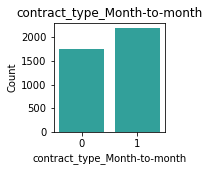

   contract_type_Month-to-month  Count  Percent
1                             1   2192    55.59
0                             0   1751    44.41
_________________________________________________________________


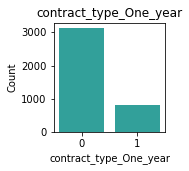

   contract_type_One_year  Count  Percent
0                       0   3122    79.18
1                       1    821    20.82
_________________________________________________________________


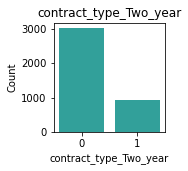

   contract_type_Two_year  Count  Percent
0                       0   3013    76.41
1                       1    930    23.59
_________________________________________________________________


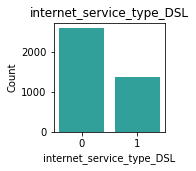

   internet_service_type_DSL  Count  Percent
0                          0   2578    65.38
1                          1   1365    34.62
_________________________________________________________________


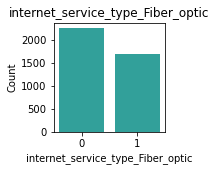

   internet_service_type_Fiber_optic  Count  Percent
0                                  0   2246    56.96
1                                  1   1697    43.04
_________________________________________________________________


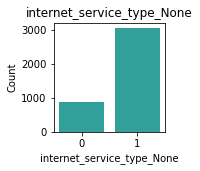

   internet_service_type_None  Count  Percent
0                           1   3062    77.66
1                           0    881    22.34
_________________________________________________________________


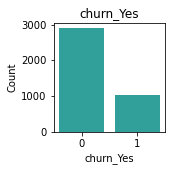

   churn_Yes  Count  Percent
0          0   2897    73.47
1          1   1046    26.53
_________________________________________________________________


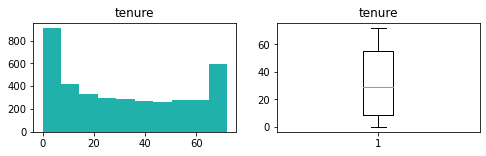

count    3943.000000
mean       32.143799
std        24.434152
min         0.000000
25%         9.000000
50%        29.000000
75%        55.000000
max        72.000000
Name: tenure, dtype: float64


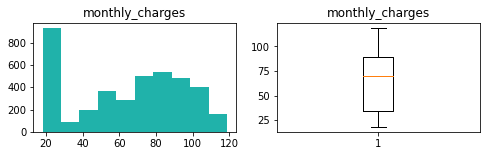

count    3943.000000
mean       64.191910
std        30.003617
min        18.250000
25%        34.700000
50%        70.050000
75%        89.425000
max       118.650000
Name: monthly_charges, dtype: float64


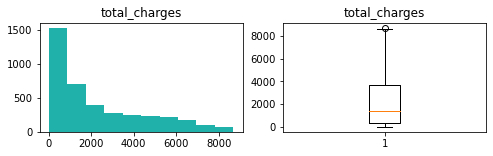

count    3943.000000
mean     2237.319706
std      2230.492855
min        18.900000
25%       399.350000
50%      1386.800000
75%      3676.625000
max      8684.800000
Name: total_charges, dtype: float64


In [8]:
cat_vars = ['contract_type_Month-to-month', 'contract_type_One_year', 'contract_type_Two_year', 'internet_service_type_DSL', 'internet_service_type_Fiber_optic', 'internet_service_type_None', 'churn_Yes']
quant_vars = ['tenure', 'monthly_charges', 'total_charges']

explore_univariate(train, cat_vars, quant_vars)

#### Hypothesis testing

We used a confidence level of 95% to test our hypotheses.

In [9]:
alpha = .05

In [10]:
# Dependency between month-to-month contracts and churn
null_hyp = "Churn is independent of month-to-month contracts."
alt_hyp = "Month-to-month contracts and churn are dependent on each other."

observed = pd.crosstab(train.churn_Yes, train['contract_type_Month-to-month'])
chi2, p, degf, expected = stats.chi2_contingency(observed)

print(f"p value is less than alpha:  {p < alpha}")

p value is less than alpha:  True


In [11]:
# Dependency between fiber and churn
null_hyp = "Churn is independent of fiber service."
alt_hyp = "Fiber service and churn are dependent on each other."

observed = pd.crosstab(train.churn_Yes, train.internet_service_type_Fiber_optic)
chi2, p, degf, expected = stats.chi2_contingency(observed)

print(f"p value is less than alpha:  {p < alpha}")

p value is less than alpha:  True


In [12]:
# Correlation between tenure and monthly charges
null_hyp = "Monthly charges do not correlate with tenure."
alt_hyp = "Monthly charges and tenure have a correlation."

corr, p = stats.pearsonr(train.monthly_charges, train.tenure)
evaluate_hypothesis_pcorrelation(corr, p, alpha=alpha, null_hypothesis=null_hyp, alternative_hypothesis=alt_hyp)

------------------------------------------
corr:  0.23760458551856645, p:  9.892794406868373e-52, a:  Monthly charges and tenure have a correlation.

We reject the null hypothesis. We move forward with the alternative hypothesis:  Monthly charges and tenure have a correlation.
Correlation direction:  positive
------------------------------------------


{'corr': 0.23760458551856645,
 'p': 9.892794406868373e-52,
 'a': 0.05,
 'reject_null': True,
 'message': 'We reject the null hypothesis. We move forward with the alternative hypothesis:  Monthly charges and tenure have a correlation.',
 'correlation': 'positive'}

In [13]:
# Month-to-month fiber customers and monthly charges 
null_hyp = "Month-to-month fiber customers do not pay more in monthly charges than other customers."
alt_hyp = "Month-to-month fiber customers do pay higher monthly charges than other customers."

monthly_fiber_customers = train[(train['contract_type_Month-to-month'] == 1) & (train.internet_service_type_Fiber_optic == 1)]
samples = monthly_fiber_customers.monthly_charges

population_mean = train.monthly_charges.mean()

t, p = stats.ttest_1samp(samples, population_mean)
evaluate_hypothesis_ttest(p, t, alpha=alpha, tails="greater", null_hypothesis=null_hyp, alternative_hypothesis=alt_hyp)

------------------------------------------
t:  70.19897136074535, p:  0.0, a:  0.05

We reject the null hypothesis. We move forward with the alternative hypothesis:  Month-to-month fiber customers do pay higher monthly charges than other customers.
------------------------------------------


{'t': 70.19897136074535,
 'p': 0.0,
 'a': 0.05,
 'message': 'We reject the null hypothesis. We move forward with the alternative hypothesis:  Month-to-month fiber customers do pay higher monthly charges than other customers.',
 'reject_null': True}

The results from the statistical testing allow us to move forward with all our alternative hypotheses:
1. Month-to-month contracts and churn are dependent on each other.
2. Fiber service and churn are dependent on each other.
3. Monthly charges and tenure have a correlation.
4. Month-to-month fiber customers do pay higher monthly charges than other customers.

#### Bivariate Exploration
Bivariate exploration using the `explore_bivariate` function demonstrated that churn rates among month-to-month (56%) and fiber customers (43%) was a greater problem than with the population. The average tenure of churned customers was 18 months compared to 37 for non-churned customers. Also, churned customers had a higher average monthly charges of 74 dollars compared to 60 dollars.

contract_type_Month-to-month 
_____________________

         chi2        p-value  degrees of freedom
0  616.510049  4.293507e-136                   1

observed:
 churn_Yes                        0     1   All
contract_type_Month-to-month                  
0                             1629   122  1751
1                             1268   924  2192
All                           2897  1046  3943

expected:
              0           1
0  1286.494294  464.505706
1  1610.505706  581.494294


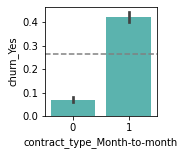


_____________________

internet_service_type_Fiber_optic 
_____________________

         chi2       p-value  degrees of freedom
0  346.000143  3.149047e-77                   1

observed:
 churn_Yes                             0     1   All
internet_service_type_Fiber_optic                  
0                                  1906   340  2246
1                                   991   706  1697
All                                2897  1046  3943

expected:
              0           1
0  1650.180573  595.819427
1  1246.819427  450.180573


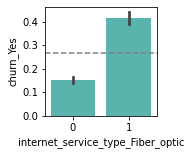


_____________________

tenure 
____________________



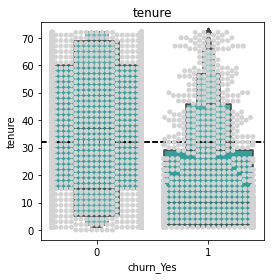

            count       mean        std  min   25%   50%   75%   max
churn_Yes                                                           
0          2897.0  37.263376  24.047706  0.0  15.0  37.0  60.0  72.0
1          1046.0  17.964627  19.380889  1.0   2.0  10.0  29.0  72.0 


Mann-Whitney Test:
 MannwhitneyuResult(statistic=2229499.0, pvalue=1.4850825655435436e-113)

____________________

monthly_charges 
____________________



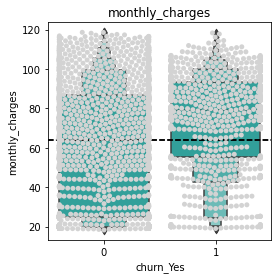

            count       mean        std    min    25%    50%      75%     max
churn_Yes                                                                    
0          2897.0  60.752951  31.034063  18.25  24.90  64.15  86.9000  118.65
1          1046.0  73.716444  24.559842  19.00  55.15  79.30  93.1875  118.35 


Mann-Whitney Test:
 MannwhitneyuResult(statistic=1151575.0, pvalue=1.0455885773558134e-30)

____________________



In [22]:
cat_vars = ['contract_type_Month-to-month', 'internet_service_type_Fiber_optic']
quant_vars = ['tenure', 'monthly_charges']
target = 'churn_Yes'

explore_bivariate(train, target, cat_vars, quant_vars)

#### Multivariate Exploration

We performed multivariate exploration using the `explore_multivariate` function.

This allowed us to find that month-to-month or fiber optic customers that churned tended to have a lower tenure. Also, month-to-month and fiber optic customers that churned tended to have higher monthly payments.

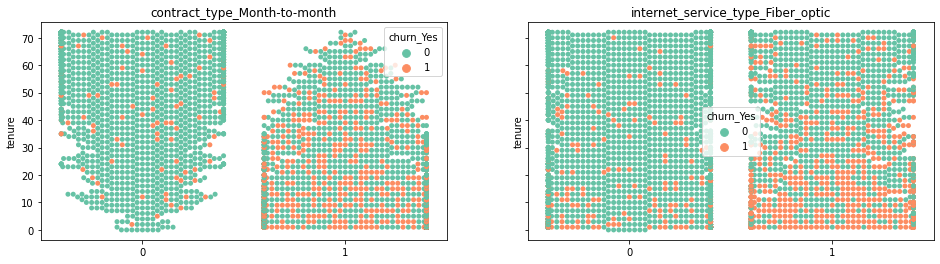

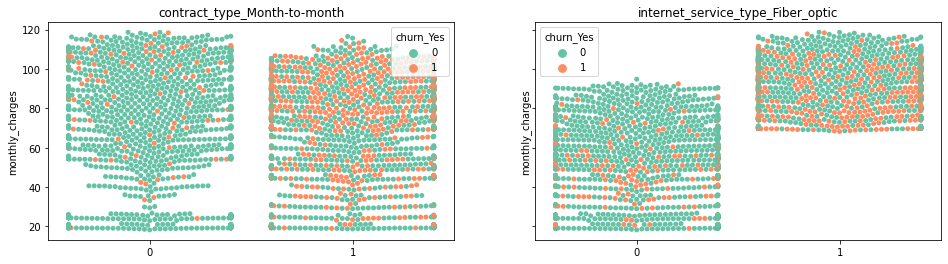

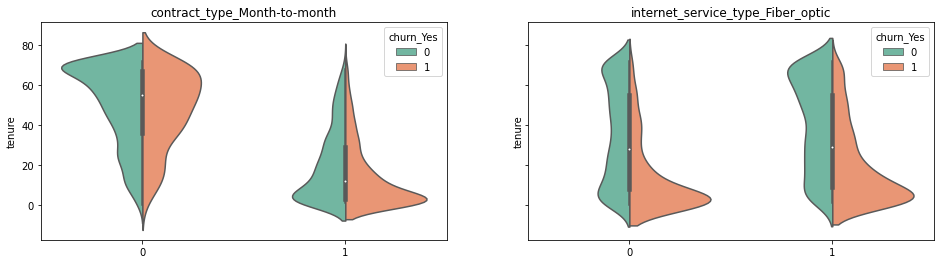

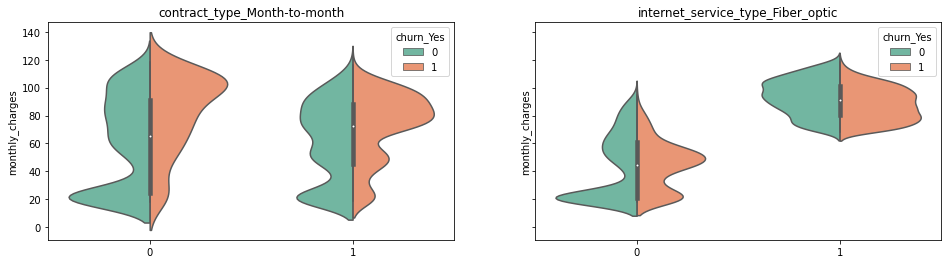

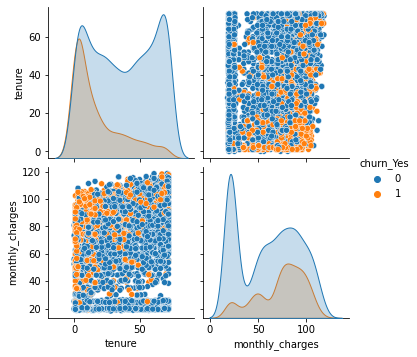

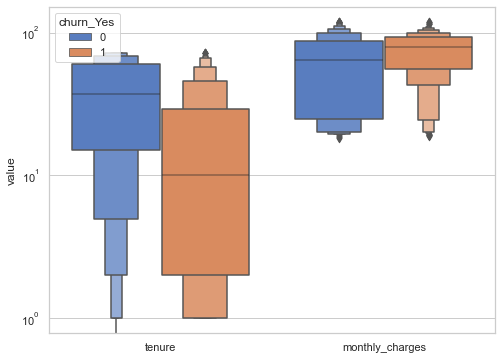

In [23]:
explore_multivariate(train, target, cat_vars, quant_vars)

## Model

We established our baseline churn value by taking the mean of the training sample and set it equal to the most common value. Then we established our baseline accuracy of 73%.

In [8]:
print(f"Average churn:  {train.churn_Yes.mean():.2%}")
train['baseline_churn'] = 0

baseline_accuracy = (train.churn_Yes == train.baseline_churn).mean()
print(f"Baseline accuracy:  {baseline_accuracy:.2%}")

train.drop(columns='baseline_churn', inplace=True)

Average churn:  26.53%
Baseline accuracy:  73.47%


Since we could move forward with all our hypotheses, we put `contract_type_Month-to-month`, `internet_service_type_Fiber_optic`, `tenure`, and `monthly_charges` into the model and dropped the rest of the columns to generate our X and y splits. From there we fit all our models to the training data and evaluated the results.

In [9]:
drop_cols = ['senior_citizen', 'total_charges', 'internet_extras', 'streaming_entertainment', 'family', 'gender_Male',
             'phone_service_Yes', 'paperless_billing_Yes', 'contract_type_One_year', 'contract_type_Two_year',
             'internet_service_type_DSL', 'internet_service_type_None', 'payment_type_Bank_transfer', 'payment_type_Credit_card',
             'payment_type_Electronic_check', 'payment_type_Mailed_check']
target = 'churn_Yes'

splits = generate_xy_splits(train, validate, test, target, drop_cols)

#### Decision Tree Model 

In [10]:
clf = DecisionTreeClassifier(max_depth=3, random_state=1414)

clf = clf.fit(splits['X_train'], splits['y_train'])

get_metrics_bin(clf, splits['X_train'], splits['y_train'])


    The accuracy for our model is 0.789
    The True Positive Rate is 0.378, The False Positive Rate is 0.0625,
    The True Negative Rate is 0.938, and the False Negative Rate is 0.622
    


,precision,recall,f1-score,support
0,0.806653,0.937522,0.867178,2897.000000
1,0.685764,0.377629,0.487053,1046.000000
accuracy,0.788993,0.788993,0.788993,0.788993
macro avg,0.746208,0.657575,0.677115,3943.000000
weighted avg,0.774583,0.788993,0.766338,3943.000000


The decision tree model performed with an overall accuracy of 79% that beats the baseline accuracy. However, it had a high false negative rate of 62% which translated into a low recall of only 38%.

#### Random Forest Model

In [11]:
rf = RandomForestClassifier(n_estimators=100, bootstrap=True, class_weight=None, criterion="gini",
                            min_samples_leaf=7, max_depth=3, random_state=1414)

rf = rf.fit(splits['X_train'], splits['y_train'])

get_metrics_bin(rf, splits['X_train'], splits['y_train'])


    The accuracy for our model is 0.7892
    The True Positive Rate is 0.401, The False Positive Rate is 0.0704,
    The True Negative Rate is 0.93, and the False Negative Rate is 0.599
    


,precision,recall,f1-score,support
0,0.811145,0.929582,0.866334,2897.000000
1,0.672552,0.400574,0.502097,1046.000000
accuracy,0.789247,0.789247,0.789247,0.789247
macro avg,0.741848,0.665078,0.684216,3943.000000
weighted avg,0.774379,0.789247,0.769709,3943.000000


The random forest model performed similarly to the decision tree with an overall accuracy of 79%. It also had a high negative rate (60%) and low recall for churn at 40%.

#### K-Nearest Neighbors Model

In [12]:
knn = KNeighborsClassifier(n_neighbors=5, weights='uniform')
knn.fit(splits['X_train'], splits['y_train'])

get_metrics_bin(knn, splits['X_train'], splits['y_train'])


    The accuracy for our model is 0.8341
    The True Positive Rate is 0.615, The False Positive Rate is 0.0866,
    The True Negative Rate is 0.913, and the False Negative Rate is 0.385
    


,precision,recall,f1-score,support
0,0.867826,0.913359,0.890010,2897.000000
1,0.719239,0.614723,0.662887,1046.000000
accuracy,0.834136,0.834136,0.834136,0.834136
macro avg,0.793532,0.764041,0.776448,3943.000000
weighted avg,0.828409,0.834136,0.829759,3943.000000


The KNN model had the best overall accuracy of 83% which beat baseline by 10%. It had the highest recall for churn at 61% and best minimized the false negative rate which was 39%.

#### Logistic Regression Model

In [13]:
log_reg = LogisticRegression(C=1, random_state=1414, intercept_scaling=1, solver='lbfgs')
log_reg.fit(splits['X_train'], splits['y_train'])

get_metrics_bin(log_reg, splits['X_train'], splits['y_train'])


    The accuracy for our model is 0.7875
    The True Positive Rate is 0.476, The False Positive Rate is 0.1,
    The True Negative Rate is 0.9, and the False Negative Rate is 0.524
    


,precision,recall,f1-score,support
0,0.826307,0.899896,0.861533,2897.000000
1,0.631980,0.476099,0.543075,1046.000000
accuracy,0.787471,0.787471,0.787471,0.787471
macro avg,0.729144,0.687998,0.702304,3943.000000
weighted avg,0.774756,0.787471,0.777053,3943.000000


The logistic regression model was the second best performing model and had an overall accuracy of 79% similar to the decision tree and random forest models, but had a better recall for churn at 48%. The false negative rate was better than the tree models at 52%, but did not minimize this rate as well as the KNN model.

#### Fine tune KNN Model and Evaluation

Since the KNN model performed much better than the other models in terms of accuracy and churn recall, we adjusted the number of neighbors taken into consideration to make the classification by adjusting the `n_neighbors` values to 3 and 10.

In [14]:
knn_10 = KNeighborsClassifier(n_neighbors=10, weights='uniform')
knn_10.fit(splits['X_train'], splits['y_train'])

get_metrics_bin(knn_10, splits['X_train'], splits['y_train'])


    The accuracy for our model is 0.8128
    The True Positive Rate is 0.459, The False Positive Rate is 0.0594,
    The True Negative Rate is 0.941, and the False Negative Rate is 0.541
    


,precision,recall,f1-score,support
0,0.828016,0.940628,0.880737,2897.000000
1,0.736196,0.458891,0.565371,1046.000000
accuracy,0.812833,0.812833,0.812833,0.812833
macro avg,0.782106,0.699760,0.723054,3943.000000
weighted avg,0.803658,0.812833,0.797077,3943.000000


Increasing the amount of neighbors decreased the accuracy and churn recall while increasing the false positive rate.

In [15]:
knn_3 = KNeighborsClassifier(n_neighbors=3, weights='uniform')
knn_3.fit(splits['X_train'], splits['y_train'])

get_metrics_bin(knn_3, splits['X_train'], splits['y_train'])


    The accuracy for our model is 0.8696
    The True Positive Rate is 0.7, The False Positive Rate is 0.069,
    The True Negative Rate is 0.931, and the False Negative Rate is 0.3
    


,precision,recall,f1-score,support
0,0.895716,0.930963,0.912999,2897.000000
1,0.785408,0.699809,0.740142,1046.000000
accuracy,0.869642,0.869642,0.869642,0.869642
macro avg,0.840562,0.815386,0.826570,3943.000000
weighted avg,0.866453,0.869642,0.867144,3943.000000


Lowering the neighbors to 3 increased accuracy to 87% and increased churn recall to 70%. The false negative rate was 30%.

#### Validation

In [16]:
get_metrics_bin(knn, splits['X_validate'], splits['y_validate'])


    The accuracy for our model is 0.7646
    The True Positive Rate is 0.477, The False Positive Rate is 0.131,
    The True Negative Rate is 0.869, and the False Negative Rate is 0.523
    


,precision,recall,f1-score,support
0,0.821157,0.868760,0.844288,1242.000000
1,0.567639,0.476615,0.518160,449.000000
accuracy,0.764636,0.764636,0.764636,0.764636
macro avg,0.694398,0.672687,0.681224,1691.000000
weighted avg,0.753842,0.764636,0.757693,1691.000000


On the validation set, the original `knn` model had an overall accuracy of 76%, churn recall of 48%, and a false negative rate of 52%. While the overall accuracy was still better than baseline, the decrease in churn recall and increase in false negative rate were about -13% and 9% respectively. 

In [17]:
get_metrics_bin(knn_10, splits['X_validate'], splits['y_validate'])


    The accuracy for our model is 0.7788
    The True Positive Rate is 0.405, The False Positive Rate is 0.0862,
    The True Negative Rate is 0.914, and the False Negative Rate is 0.595
    


,precision,recall,f1-score,support
0,0.809558,0.913849,0.858548,1242.000000
1,0.629758,0.405345,0.493225,449.000000
accuracy,0.778829,0.778829,0.778829,0.778829
macro avg,0.719658,0.659597,0.675886,1691.000000
weighted avg,0.761817,0.778829,0.761546,1691.000000


`knn_10` had the best overall accuracy on the validation data at 78%, but had a 5% decrease in churn recall to 41% and a 6% increase in the false negative rate to 60%.

In [18]:
get_metrics_bin(knn_3, splits['X_validate'], splits['y_validate'])


    The accuracy for our model is 0.764
    The True Positive Rate is 0.514, The False Positive Rate is 0.146,
    The True Negative Rate is 0.854, and the False Negative Rate is 0.486
    


,precision,recall,f1-score,support
0,0.829554,0.854267,0.841729,1242.000000
1,0.560680,0.514477,0.536585,449.000000
accuracy,0.764045,0.764045,0.764045,0.764045
macro avg,0.695117,0.684372,0.689157,1691.000000
weighted avg,0.758162,0.764045,0.760707,1691.000000


`knn_3` suffered an 11% decrease in overall accuracy to 76%, but this still performed slightly better than our baseline accuracy of 73%. Both the churn recall and false negative rates changed by 19% with the churn recall decreasing to 51% while the false negative rate increased to 49%.

#### Testing

Despite not having the best overall accuracy in the validation phase, we chose `knn_3` as our best model to predict churn. We considered false negatives to be costly since retaining customers is less costly than securing new ones, so we prioritized maximizing churn recall and minimizing the false negative rate, which was accomplished by `knn_3`.

In [19]:
get_metrics_bin(knn_3, splits['X_test'], splits['y_test'])


    The accuracy for our model is 0.7587
    The True Positive Rate is 0.479, The False Positive Rate is 0.14,
    The True Negative Rate is 0.86, and the False Negative Rate is 0.521
    


,precision,recall,f1-score,support
0,0.820276,0.859903,0.839623,1035.000000
1,0.552469,0.478610,0.512894,374.000000
accuracy,0.758694,0.758694,0.758694,0.758694
macro avg,0.686373,0.669257,0.676258,1409.000000
weighted avg,0.749191,0.758694,0.752897,1409.000000


`knn_3` had an overall accuracy of 76%, churn recall of 48%, and false negative rate of 52% on the test data. While the overall accuracy beat our baseline accuracy by 3%, a higher churn recall and lower false negative rate would be better.

## Delivery

We reconstructed the population data set with only the selected features by concatenating the X_train, X_validate, and X_test splits into the `telco_population` dataframe. From there we predicted the outcomes using our `knn_3` model and also calculated the probability of each outcome. The `customer_id` was added back from the original `telco_df` and the three dataframes were concatenated to create `customer_predictions` which is exported as **customer_predictions.csv** with `customer_id`, `churn_probability`, and `churn_prediction` for each customer. The original results can be found [here](https://drive.google.com/file/d/18vnvnSJPfsEhv2MpF-X3bKvr3kAHr6uX/view?usp=sharing). 

In [20]:
telco_population = pd.concat([splits['X_train'], splits['X_validate'], splits['X_test']])

model_pred = knn_3.predict(telco_population)
prediction = pd.DataFrame(model_pred)
prediction.rename(columns={0 : 'churn_prediction'}, inplace=True)

model_pred_proba = knn_3.predict_proba(telco_population)
prediction_prob = pd.DataFrame(model_pred_proba[0:,1]) # only take the second position which is probability of churn being True
prediction_prob.rename(columns={0 : 'churn_probability'}, inplace=True)

customer_predictions = pd.concat([telco_df.customer_id, prediction_prob, prediction], axis=1)

customer_predictions.to_csv("customer_predictions.csv")

#### Key Takeaways
1. Overall churn rate is only 27%, but increases to 56% and 43% among month-to-month and fiber customers, respectively.
2. Tenure for churned customers significantly lower than non-churned customers and even lower in those key groups.
3. Monthly charges for churned customers is higher than non-churned and even higher in key groups, especially month-to-month.

#### Recommendations
1. Reduce monthly cost and incentivize tenure
    * Lower price of fiber optic service
    * Reduce monthly cost by certain percentage after 12 months of on-time payments
2. Continue fine tuning model
    * Remove tenure and re-evaluate
    * Aim for 85% accuracy, 60% churn recall, and 40% false negative rate
3. Explore other features
    * Paperless billing customers seemed to churn at a high rate as well. Why?!
    * Created features (`family`, `internet_extras`, `streaming_entertainment`) that we did not have an opportunity to utilize